In [1]:
#[Private_6th] klue_roberta-large + R-Drop Los 코드 참고
#필요한 라이브러리 가져오기
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import multiprocessing
import datasets
import collections
import transformers
from datasets import Dataset
from tqdm.notebook import tqdm

from transformers import (
    AutoConfig,
    AutoTokenizer,
    TrainingArguments,
    DataCollatorWithPadding,
)

import warnings

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#경고 무시
warnings.filterwarnings(action='ignore')

In [3]:
#seed 고정
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    np.random.default_rng(seed)
    random.seed(seed)

In [4]:
#일단 SEED =1 부터
SEED = 1

In [5]:
seed_everything(SEED)

In [6]:
#하이퍼 파라미터 세팅 -> 일단 데이터 증강을 할 때는 필요 없어
PLM = 'klue/roberta-large'
OUTPUT_DIR = './exps'
NUM_PROC = 1
TRAIN_BATCH_SIZE = 16
NUM_EPOCH = 3
WEIGHT_DECAY = 1e-3
WARMUP_RATIO = 0.05
LEARNING_RATE = 2.5e-5
SAVE_STEPS = 500
MAX_LENGTH = 128
MINIMUM_SIZE = 20
MAXIMUM_SIZE = 80
LOGGING_STEPS = 100
CPU_COUNT = multiprocessing.cpu_count() // 2

In [8]:
#raw 데이터셋 가져오기, 어차피 증강을 위해 내가 사용할 수 있는 데이터는 train 데이터밖에 없어
data_dir = './dataset'
train_data_file = 'train.csv'

file_path = os.path.join(data_dir, train_data_file)
df = pd.read_csv(file_path)
df = df.drop_duplicates(subset=['문장']) #중복된 문장 지우기
df.head()

,ID,문장,유형,극성,시제,확실성,label
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실


### Encoding dataset

In [14]:
model_name = PLM #하이퍼 파라미터에서 이미 지정해둠
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True) # hugging face 에 공유된 language model 들은 이미 pretrain 되어 있기 때문에 tokenizer 도 이미 포함되어 있다고 생각하면 될 것 같다.

In [15]:
#인코더 클래스 정의
class Encoder :

    def __init__(self, tokenizer, max_input_length, label_dict=None, train_flag=True) :
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.label_dict = label_dict
        self.train_flag = train_flag

    def __call__(self, examples) :

        # 입력 문장 tokenizer를 통해서 인코딩
        inputs = examples['문장']
        model_inputs = self.tokenizer(inputs, 
            max_length=self.max_input_length, 
            return_token_type_ids=False,
            truncation=True,
        )

        # 학습을 위한 인코더인 경우 label을 인덱스로 인코딩
        if self.train_flag :
            model_inputs['labels'] = [self.label_dict[l] for l in examples['label']]

        return model_inputs

In [16]:
encoder = Encoder(tokenizer, MAX_LENGTH, label_dict)

In [17]:
dataset = dataset.map(encoder, batched=True, num_proc=CPU_COUNT)

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

#4:   0%|          | 0/1 [00:00<?, ?ba/s]

#5:   0%|          | 0/1 [00:00<?, ?ba/s]

#6:   0%|          | 0/1 [00:00<?, ?ba/s]

 Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction


#7:   0%|          | 0/1 [00:00<?, ?ba/s]

#8:   0%|          | 0/1 [00:00<?, ?ba/s]

#9:   0%|          | 0/1 [00:00<?, ?ba/s]

#10:   0%|          | 0/1 [00:00<?, ?ba/s]

#11:   0%|          | 0/1 [00:00<?, ?ba/s]

#12:   0%|          | 0/1 [00:00<?, ?ba/s]

#13:   0%|          | 0/1 [00:00<?, ?ba/s]

#14:   0%|          | 0/1 [00:00<?, ?ba/s]

#15:   0%|          | 0/1 [00:00<?, ?ba/s]

 Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
 

#16:   0%|          | 0/1 [00:00<?, ?ba/s]

#17:   0%|          | 0/1 [00:00<?, ?ba/s]

#18:   0%|          | 0/1 [00:00<?, ?ba/s]

#19:   0%|          | 0/1 [00:00<?, ?ba/s]

#20:   0%|          | 0/1 [00:00<?, ?ba/s]

#21:   0%|          | 0/1 [00:00<?, ?ba/s]

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction


#22:   0%|          | 0/1 [00:00<?, ?ba/s]

#23:   0%|          | 0/1 [00:00<?, ?ba/s]

#24:   0%|          | 0/1 [00:00<?, ?ba/s]

#25:   0%|          | 0/1 [00:00<?, ?ba/s]

#26:   0%|          | 0/1 [00:00<?, ?ba/s]

#27:   0%|          | 0/1 [00:00<?, ?ba/s]

#28:   0%|          | 0/1 [00:00<?, ?ba/s]

#30:   0%|          | 0/1 [00:00<?, ?ba/s]

#29:   0%|          | 0/1 [00:00<?, ?ba/s]

#31:   0%|          | 0/1 [00:00<?, ?ba/s]

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction


In [19]:
df_before_augmented = dataset.to_pandas()
df_before_augmented

,ID,문장,유형,극성,시제,확실성,label,__index_level_0__,input_ids,attention_mask,labels
0,TRAIN_00000,0.75%포인트 금리 인상은 1994년 이후 28년 만에 처음이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실,0,"[0, 20, 18, 5951, 9, 4648, 4527, 4344, 2073, 7...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
1,TRAIN_00001,이어 ＂앞으로 전문가들과 함께 4주 단위로 상황을 재평가할 예정＂이라며 ＂그 이전이...,사실형,긍정,과거,확실,사실형-긍정-과거-확실,1,"[0, 3796, 1980, 1388, 6233, 4205, 2031, 2145, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
2,TRAIN_00002,정부가 고유가 대응을 위해 7월부터 연말까지 유류세 인하 폭을 30%에서 37%까지...,사실형,긍정,미래,확실,사실형-긍정-미래-확실,2,"[0, 3659, 2116, 6870, 2116, 4509, 2069, 3627, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
3,TRAIN_00003,"서울시는 올해 3월 즉시 견인 유예시간 60분을 제공하겠다고 밝혔지만, 하루 만에 ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실,3,"[0, 5087, 2259, 3753, 23, 2429, 6832, 10947, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
4,TRAIN_00004,익사한 자는 사다리에 태워 거꾸로 놓고 소금으로 코를 막아 가득 채운다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실,4,"[0, 1505, 2063, 2470, 5105, 16416, 2170, 13920...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
...,...,...,...,...,...,...,...,...,...,...,...
16501,TRAIN_16535,"이에 따라 대형 콘서트부터 야외 페스티벌, 실내 공연 등 연이어 오픈 소식이 들려오...",사실형,긍정,현재,확실,사실형-긍정-현재-확실,16535,"[0, 1504, 2170, 3653, 4477, 6665, 3797, 8296, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
16502,TRAIN_16536,"＇신동덤＇은 ＇신비한 동물사전＇과 ＇해리 포터＇ 시리즈를 잇는 마법 어드벤처물로, ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실,16536,"[0, 3, 9515, 2840, 3, 1497, 3, 7635, 2470, 480...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
16503,TRAIN_16537,"수족냉증은 어릴 때부터 심했으며 관절은 어디 한 곳이 아니고 목, 어깨, 팔꿈치, ...",사실형,긍정,과거,확실,사실형-긍정-과거-확실,16537,"[0, 19261, 2576, 2304, 2073, 8115, 904, 3797, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
16504,TRAIN_16538,김금희 소설가는 ＂계약서 조정이 그리 어려운가 작가를 격려한다면서 그런 문구 하나 ...,사실형,긍정,과거,확실,사실형-긍정-과거-확실,16538,"[0, 648, 2157, 2364, 10173, 2259, 1980, 10456,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1


In [20]:
class Augmentation :

    def __init__(self, tokenizer, max_num, min_num, reduction=0.65, undersampling_ratio=0.65, eval_flag=True) :
        self.tokenizer = tokenizer
        self.max_num = max_num
        self.min_num = min_num
        self.reduction = reduction
        self.undersampling_ratio = undersampling_ratio
        self.punct = [".", ";", "?", ":", "!", ","]
        self.eval_flag = eval_flag

    def __call__(self, dataset):
        
        labels = dataset['label']

        # 각 Label별로 Index들을 정리한다.
        label_ids = collections.defaultdict(list)
        for i, l in enumerate(labels) :
            label_ids[l].append(i)

        # 각 Label 별로 데이터 크기에 따라서 undersampling, dataaugmentation을 따로 진행한다.
        total_id_list = []
        for l in label_ids :
            id_list = label_ids[l]
            previous_size = len(id_list) # 기존 데이터 갯수

            # 최소 갯수 보다 많으면 데이터 증강을 하지 않음 (20개)
            if previous_size > self.min_num : 
                if self.eval_flag :
                    # validation을 할 때는 이미 Validation을 할 때 20%를 각 Label에서 가져가끼 때문에 그대로
                    augmentated_id_list = id_list
                else :
                    # traina만 할 때는 validation과 같은 환경을 맞추기 위해서 각 전체 데이터 수의 80%만을 선정
                    ## 전체 데이터를 다 쓰는 것보다 특정 비율을 가지고 임의로 선택하고 모델들을 앙상블 했을 때 더 좋은 효과를 가질 것이라고 판단
                    sample_size = int(len(id_list) * self.reduction)
                    augmentated_id_list = random.sample(id_list, sample_size)

                # 최대 갯수보다 많으면 (3000개)
                if len(augmentated_id_list) > self.max_num : 
                    # 데이터 수의 80%를 임의 선택
                    augmentated_id_list = random.sample(
                        augmentated_id_list, 
                        int(len(augmentated_id_list) * self.undersampling_ratio)
                    )

                # (index, status) 구조로 저장
                # status 0 : 데이터 변형 대상 아님, status : 1 데이터 변형 대상
                augmentated_id_list = [(a_id, 0) for a_id in augmentated_id_list]
            
            # 최소 갯수 보다 많으면 데이터 증강을 진행 (20개)
            else :
                # 기존 데이터
                augmentated_id_list = [(a_id, 0) for a_id in id_list]
                # 기존 데이터를 복사 (20개가 넘을 떼 까지)
                while len(id_list) < self.min_num :
                    id_list = id_list * 2

                # 기존 데이터 + 복사된 변형 될 데이터 해서 20개를 맞춘다.
                augmentated_id_list = augmentated_id_list + \
                    [(a_id, 1) for a_id in random.sample(id_list, self.min_num - previous_size)]

            print('Category : %s \t Previous size : %d, Current size : %d' %(l, previous_size, len(augmentated_id_list)))

            total_id_list.extend(augmentated_id_list)

        org_size, add_size = 0, 0
        for _, status in total_id_list :
            if status == 0 :
                org_size += 1
            else :
                add_size += 1
        print('Original data size : %d \t Augment data size : %d' %(org_size, add_size))

        # 데이터 셔플
        random.shuffle(total_id_list)
            
        # huggingface를 사용하기 때문에 datasets class 형식으로 맞춤
        total_dataset = []
        for i, status in tqdm(total_id_list) :
            data = self.augment(dataset[i], status)
            total_dataset.append(data)

        df = pd.DataFrame(total_dataset)
        dataset = Dataset.from_pandas(df)
        return dataset

    # aeda를 통한 문장 변형
    """ 
    예시
        before : '단 어떤 영웅도 2주 연속 제외되지 않으며 영웅 로테이션은 팬, 선수 등의 의견을 적극 수렴해 시즌 중에도 수정될 수 있다.'
        after : '단, 어떤 영웅도 2주 연속 제외되지 않으며 영웅 로테:이션은 팬, 선수 등의 의견을 적극 수렴해 시즌 중에도 수정될 수 있다.'
    """
    def aeda(self, data) :
        sentence = data['문장']
        # 구두점 삽입 횟수
        insert_size = np.random.randint(1, len(sentence) // 5)
        
        chars = list(sentence)
        while insert_size > 0 :
            # 구두점 선택
            punct_id = np.random.randint(len(self.punct))
            punct = self.punct[punct_id]

            # 구두점 삽입 위치 선정
            insert_id = np.random.randint(len(chars))
            # 구두점 삽입
            chars = chars[:insert_id] + [punct] + chars[insert_id:]

            insert_size -= 1

        sentence = ''.join(chars)
        data['문장'] = sentence
        return data

    # 문장 내의 몇몇 단어들을 임의의 단어로 변환
    """
    예시
        before : '확실히 백내장 진단을 받았어도 입원 치료를 받을 만큼 특별한 상황이었음을 입증하지 못하면 30만원 이상의 보험금을 받기 어려울 전망이다.'
        after : '확실히 백 된장 진단을 받았어도 입원 치료를 받을 만큼 특별한 보잘것없이 운전음을 입증하지 못하면 30으리원 원단의 보험금을 받 고등학생 어려울 전망이다.'
    """
    def change(self, data) :
        sentence = data['문장']
        # tokenizer를 통해서 index들로 변환
        tokens = self.tokenizer.encode(sentence)[1:-1]

        # 바꾸는 단어 수 선택 (문장의 길이에 따라서 달라진다.)
        change_size = int(len(tokens) * 0.15)
        
        if change_size > 0 :
            change_ids = random.sample(range(len(tokens)), change_size)
            for c_id in change_ids :
                tokens[c_id] = np.random.randint(len(self.tokenizer))

            data['문장'] = self.tokenizer.decode(tokens)
        return data

    # 문장의 순서 바꾸기
    """
    예시
        before : '그렇다면 차천로는 과연 어떤 비석을 두고 이런 말을 했던 걸까.'
        after : '비석을 두고 이런 말을 했던 걸까. 그렇다면 차천로는 과연 어떤'
    """
    def reverse(self, data) :
        sentence = data['문장']
        words = sentence.split(' ')

        if len(words) > 5 :   
            index = np.random.randint(1, len(words) - 1)
            reversed = words[index:] + words[:index]
            sentence = ' '.join(reversed)

        data['문장'] = sentence
        return data

    # 문장의 단어 삭제
    """
    예시
        before : '이것이 만약 상업적인 의도였다면 이렇게까지 하지 못했을 것이다.'
        after : '이것이 만약 상업적인 의도였다면 이렇게까지 하지 것이다.'
    """
    def delete(self, data) :

        sentence = data['문장']
        words = sentence.split(' ')

        if len(words) > 5 :   
            word_size = len(words)
            # 삭제 단어 횟수 선정 (문장의 길이에 따라서 정해진다.)
            del_size = int(word_size * 0.2)
            # 삭제 단어 위치 선정
            del_indices = random.sample(range(word_size), del_size)

            deleted = []
            for i, word in enumerate(words) :
                if i in del_indices :
                    continue
                deleted.append(word)

            sentence = ' '.join(deleted)

        data['문장'] = sentence
        return data


    def augment(self, data, status) :
        if status == 0 :
            return data
        else :
            option = np.random.randint(4)
            if option == 0 :
                data = self.aeda(data)
            elif option == 1 :
                data = self.reverse(data)
            elif option == 2 :
                data = self.delete(data)
            else :
                data = self.change(data)
            
            return data



In [21]:
augmentator = Augmentation(
    tokenizer=tokenizer,
    max_num=MAXIMUM_SIZE, 
    min_num=MINIMUM_SIZE, 
    eval_flag=False
)

In [22]:
#일단 데이터셋을 클래스별 개수로만 봤을 때, 개수가 조정됨. (클래스별로 개수가 많던 클래스는 개수가 줄었고, 개수가 적던 클래스는 개수가 늘었다.)
dataset_augmented = augmentator(dataset)

Category : 사실형-긍정-현재-확실 	 Previous size : 4733, Current size : 1999
Category : 사실형-긍정-과거-확실 	 Previous size : 7098, Current size : 2998
Category : 사실형-긍정-미래-확실 	 Previous size : 648, Current size : 273
Category : 추론형-부정-현재-확실 	 Previous size : 93, Current size : 60
Category : 예측형-긍정-미래-불확실 	 Previous size : 141, Current size : 59
Category : 추론형-긍정-현재-확실 	 Previous size : 1099, Current size : 464
Category : 추론형-긍정-과거-확실 	 Previous size : 334, Current size : 141
Category : 추론형-긍정-현재-불확실 	 Previous size : 130, Current size : 54
Category : 대화형-긍정-미래-확실 	 Previous size : 26, Current size : 16
Category : 사실형-미정-현재-확실 	 Previous size : 18, Current size : 20
Category : 사실형-부정-과거-확실 	 Previous size : 183, Current size : 76
Category : 예측형-부정-과거-확실 	 Previous size : 1, Current size : 20
Category : 추론형-긍정-미래-확실 	 Previous size : 204, Current size : 85
Category : 사실형-긍정-미래-불확실 	 Previous size : 236, Current size : 99
Category : 대화형-긍정-현재-확실 	 Previous size : 255, Current size : 107
Category : 사실형-부

  0%|          | 0/7726 [00:00<?, ?it/s]

### 증강이 잘 되었는지 확인

In [23]:
df_augmented = dataset_augmented.to_pandas()
df_augmented

,ID,문장,유형,극성,시제,확실성,label,__index_level_0__,input_ids,attention_mask,labels
0,TRAIN_00722,하이 브랜드의 정점에 있는 에르메스의 도산파크 매장 지하에 위치한 레스토랑이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실,722,"[0, 4899, 4183, 2079, 12067, 2170, 1513, 2259,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
1,TRAIN_08482,＂미래의 시간은 우리 세대가 경험한 것과 근본적으로 다를 것＂이라는 선언과 함께 이...,사실형,긍정,현재,확실,사실형-긍정-현재-확실,8482,"[0, 1980, 4037, 2079, 3641, 2073, 3616, 4489, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
2,TRAIN_06286,1994년 이 책으로 이름을 날린 그는 작년 말 이코노미스트지가 같은 제목으로 낸 ...,사실형,긍정,과거,확실,사실형-긍정-과거-확실,6286,"[0, 7756, 2440, 1504, 1644, 6233, 3934, 2069, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
3,TRAIN_01379,반려인들의 1순위 소원은 반려동물이 ＂나 아파＂라는 말이라도 해 줬으면 하는 것이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실,1379,"[0, 8975, 2179, 2031, 2079, 21, 22247, 8365, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
4,TRAIN_02644,"학점은행제 학습자는 매테 800점 이상 취득 시 20학점, 600점 이상 취득 시 ...",사실형,긍정,현재,확실,사실형-긍정-현재-확실,2644,"[0, 12447, 4701, 2021, 4611, 2155, 2259, 1050,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
...,...,...,...,...,...,...,...,...,...,...,...
7721,TRAIN_09695,농협은 신종 코로나바이러스로부터 농업인과 고객 안전을 지키기 위해 금융혜택 지원 등...,사실형,긍정,과거,확실,사실형-긍정-과거-확실,9695,"[0, 6470, 2073, 9310, 1726, 11235, 8023, 4968,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
7722,TRAIN_13383,"실제로 두 회사가 거둔 수출액은 지난해 각각 7135억원, 3079억원에 달했다.",사실형,긍정,과거,확실,사실형-긍정-과거-확실,13383,"[0, 4539, 864, 3769, 2116, 9443, 17430, 2073, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
7723,TRAIN_13947,건물 내부는 아치를 반복해 부드러운 분위기를 연출했다.,사실형,긍정,과거,확실,사실형-긍정-과거-확실,13947,"[0, 4515, 4492, 2259, 19491, 2138, 5205, 2097,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
7724,TRAIN_14872,"미국의 ＇브레인 이니셔티브(BRAIN Initiative)＇, 유럽연합의 ＇휴먼브레...",사실형,긍정,현재,확실,사실형-긍정-현재-확실,14872,"[0, 3666, 2079, 3, 17582, 19418, 2415, 6210, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0


<AxesSubplot:xlabel='labels', ylabel='Count'>

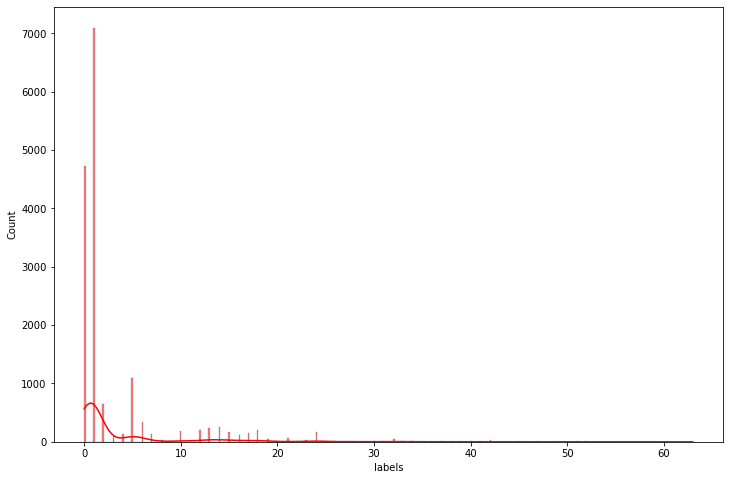

In [24]:
#개수에 대한 변화 - 그래프 그려서 previous 와 current 의 차이를 보여주기
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (12,8))

sns.histplot(x=df_before_augmented['labels'], kde= True, stat='count', color='red') #before

<AxesSubplot:xlabel='labels', ylabel='Count'>

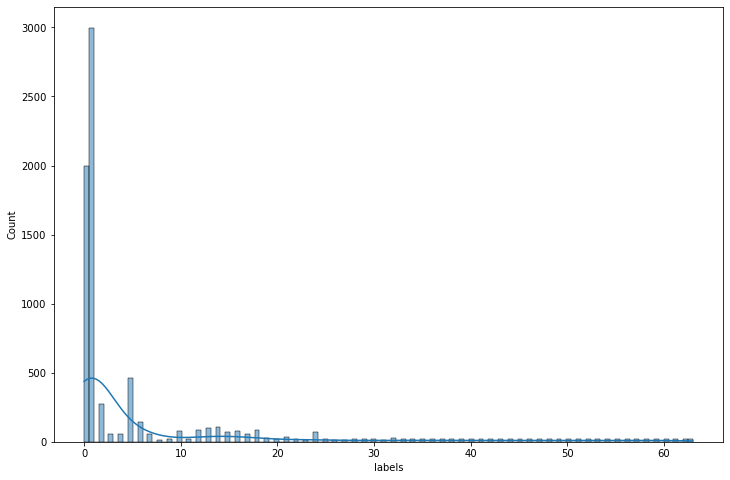

In [25]:
plt.figure(figsize = (12,8))

sns.histplot(x=df_augmented['labels'], kde= True, stat='count') #after

<AxesSubplot:xlabel='labels', ylabel='Count'>

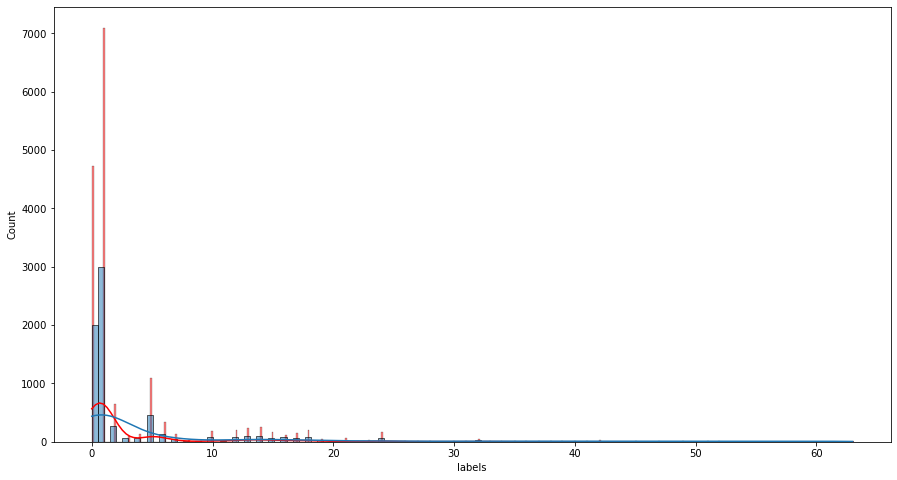

In [26]:
plt.figure(figsize = (15,8)) #2개 같이 한 번에 그림

sns.histplot(x=df_before_augmented['labels'], kde= True, stat='count', color='red') #before
sns.histplot(x=df_augmented['labels'], kde= True, stat='count') #after

In [27]:
#쓸만한 증강인가? - 클래스를 임의 샘플링해서 눈으로 직접 확인하기
df_augmented[df_augmented['label'].str.contains('예측형-미정-과거-확실')]

,ID,문장,유형,극성,시제,확실성,label,__index_level_0__,input_ids,attention_mask,labels
112,TRAIN_15844,아직은 있어 전반적인 로드맵을 그리는 수준으로 향후 적합한 게임들이 갈라게임즈를 통...,예측형,미정,과거,확실,예측형-미정-과거-확실,15844,"[0, 3919, 2073, 6209, 4474, 2170, 1513, 2051, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",63
215,TRAIN_15844,아직썸 이스포츠에 있어 전반적인 로드맵 표기 그리는 수준으로 향후 류중일포츠에 적합...,예측형,미정,과거,확실,예측형-미정-과거-확실,15844,"[0, 3919, 2073, 6209, 4474, 2170, 1513, 2051, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",63
929,TRAIN_15844,아직은 이스포츠에 있어 전반적인 로드맵을 수준으로 향후 이스포츠에 적합한 게임들이 ...,예측형,미정,과거,확실,예측형-미정-과거-확실,15844,"[0, 3919, 2073, 6209, 4474, 2170, 1513, 2051, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",63
986,TRAIN_15844,"아직;은 이스포츠에 있어? 전반적인 로드맵을 그리는.. 수준으로 ;향?후 !,이스포...",예측형,미정,과거,확실,예측형-미정-과거-확실,15844,"[0, 3919, 2073, 6209, 4474, 2170, 1513, 2051, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",63
1773,TRAIN_15844,아직은 이스포츠에 있어 전반적인 로드맵 소생 그리 역관 수준으로 향후 이스포츠 튕겨...,예측형,미정,과거,확실,예측형-미정-과거-확실,15844,"[0, 3919, 2073, 6209, 4474, 2170, 1513, 2051, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",63
1997,TRAIN_15844,아직은 이스포츠에 있어 전반적인 로드맵을 그리는 수준으로 향후 이스포츠에 적합한 게...,예측형,미정,과거,확실,예측형-미정-과거-확실,15844,"[0, 3919, 2073, 6209, 4474, 2170, 1513, 2051, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",63
2287,TRAIN_15844,계속 공개될 것이다. 아직은 이스포츠에 있어 전반적인 로드맵을 그리는 수준으로 향후...,예측형,미정,과거,확실,예측형-미정-과거-확실,15844,"[0, 3919, 2073, 6209, 4474, 2170, 1513, 2051, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",63
3118,TRAIN_15844,아직은 이.스포츠에 있어 전반적인 로드맵을 그리는 수준으로 향!후 이스포츠에 적합한...,예측형,미정,과거,확실,예측형-미정-과거-확실,15844,"[0, 3919, 2073, 6209, 4474, 2170, 1513, 2051, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",63
3178,TRAIN_15844,아직은 이스포츠에 투쟁어 전반 강했 로드맵을 그리는 거머쥐으로 향후 이스포츠에 적합...,예측형,미정,과거,확실,예측형-미정-과거-확실,15844,"[0, 3919, 2073, 6209, 4474, 2170, 1513, 2051, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",63
3528,TRAIN_15844,아직은 이스포츠에 있어 전반적인 암행을 그리는 수준으로 향후 로이시오에 적합한 게임...,예측형,미정,과거,확실,예측형-미정-과거-확실,15844,"[0, 3919, 2073, 6209, 4474, 2170, 1513, 2051, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",63


In [32]:
df_final_augmented = df_augmented.loc[:, ['ID', '문장', '유형', '극성', '시제', '확실성', 'label']]
df_final_augmented.to_csv('./dataset/df_augmented_.csv',index = False)
df_final_augmented


,ID,문장,유형,극성,시제,확실성,label
0,TRAIN_00722,하이 브랜드의 정점에 있는 에르메스의 도산파크 매장 지하에 위치한 레스토랑이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
1,TRAIN_08482,＂미래의 시간은 우리 세대가 경험한 것과 근본적으로 다를 것＂이라는 선언과 함께 이...,사실형,긍정,현재,확실,사실형-긍정-현재-확실
2,TRAIN_06286,1994년 이 책으로 이름을 날린 그는 작년 말 이코노미스트지가 같은 제목으로 낸 ...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
3,TRAIN_01379,반려인들의 1순위 소원은 반려동물이 ＂나 아파＂라는 말이라도 해 줬으면 하는 것이다.,사실형,긍정,현재,확실,사실형-긍정-현재-확실
4,TRAIN_02644,"학점은행제 학습자는 매테 800점 이상 취득 시 20학점, 600점 이상 취득 시 ...",사실형,긍정,현재,확실,사실형-긍정-현재-확실
...,...,...,...,...,...,...,...
7721,TRAIN_09695,농협은 신종 코로나바이러스로부터 농업인과 고객 안전을 지키기 위해 금융혜택 지원 등...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
7722,TRAIN_13383,"실제로 두 회사가 거둔 수출액은 지난해 각각 7135억원, 3079억원에 달했다.",사실형,긍정,과거,확실,사실형-긍정-과거-확실
7723,TRAIN_13947,건물 내부는 아치를 반복해 부드러운 분위기를 연출했다.,사실형,긍정,과거,확실,사실형-긍정-과거-확실
7724,TRAIN_14872,"미국의 ＇브레인 이니셔티브(BRAIN Initiative)＇, 유럽연합의 ＇휴먼브레...",사실형,긍정,현재,확실,사실형-긍정-현재-확실
